In [1]:
%load_ext autoreload
%matplotlib inline  
%reload_ext autoreload
__author__ = 'ewan'
import numpy as np
import sys
sys.path.append("../src/") 
import matplotlib.pyplot as plt
import WindFarm as wf # Fusedwake wind farm model from JUAN
import WindTurbine as wt # Fusedwake wind turbine model from JUAN
import pandas as pd
from DWM_GClarsenPicks import get_Rw
from scipy.interpolate import interp1d
from scipy.integrate import quad


In [2]:
def LoadOutputs(folder,vWD,WF,WS,TI):
    powers=np.zeros((len(range(WF.nWT)),len(vWD)))
    ref_powers=[]
# for iD in range(0,1):
    for iD in np.arange(0,len(vWD),1):
        WD=float(vWD[iD])
        filename= folder +'/dwm_WS_'+ str(WS) +'_dir_' + str(WD)+'_TI_' + str(TI) +'.npy'
        # print filename
        try:
            out=np.load(filename).item()
            for iK in range(WF.nWT):
                powers[iK,iD]=out[str(iK)][0] # BEM
#                 powers[iK,iD]=out[str(iK)][4] # power curve
            ref_powers.append(max(powers[:,iD]))
        except:
            for iK in range(WF.nWT):
                powers[iK,iD]=np.nan
            ref_powers.append(np.nan)

    return powers, ref_powers

def my_rolling_deg(df, x='wd', y='power', dwd=2.5):
    inte = interp1d(df[x], df[y])
    inte2 = lambda x_: inte(ism360(x_, df[x].max()))
    def filter_func(d):
        return {y:quad(inte2, d-dwd, d+dwd)[0]/(2.*dwd),x:d}
    return pd.DataFrame(map(filter_func, df[x]))

# Pierre Elouan Rethore functions
def ism360(v, endp):
    """Make sure the direction is in [0.0, 360]"""
    if np.isnan(v):
        return v
    if v>=0.0:
        if v>endp and v<360.0:
            return endp
        elif v>=360.0:
            return v - 360.0
        else:
            return v
    else:
        return ism360(v + 360.0, endp)

In [3]:
WTG='NY2'
WS = 9.0;TI = 0.06;WTcoord='../data/Lill_full.dat'; WTspec='../WT-data/'+WTG+'/'+WTG+'_PC.dat'; HH=65.0; R=46.5; stab='N';
WT = wt.WindTurbine('Siemens 2.3MW 93m offshore',WTspec,65,46.5)
WF = wf.WindFarm('Lillgrund',WTcoord,WT)
vWD = np.arange(0.,360.,1)
mech_to_elec=0.94

In [4]:
# Dominant wake superposition
folder='../../DWMpython/outputs/Dom/'

powers, ref_powers = LoadOutputs(folder,vWD,WF,WS,TI)
powers_dominant=sum(powers)
dwm_dominant_o= pd.DataFrame({'wd':vWD, 'power':powers_dominant})
nom_power=WT.get_P(WS)
dwm_dominant_o['eff'] = dwm_dominant_o['power'] / (nom_power * WF.nWT)

# Quadratic wake superposition
folder='../../DWMpython/outputs/Quad/' 
powers, ref_powers = LoadOutputs(folder,vWD,WF,WS,TI)
powers_quadratic=sum(powers)
dwm_quadratic_o= pd.DataFrame({'wd':vWD, 'power':powers_quadratic})
dwm_quadratic_o['eff'] = dwm_quadratic_o['power'] / (nom_power* WF.nWT)

# Linear wake superposition
folder='../../DWMpython/outputs/Lin/'
powers, ref_powers = LoadOutputs(folder,vWD,WF,WS,TI)
powers_linear=sum(powers)
dwm_linear_o= pd.DataFrame({'wd':vWD, 'power':powers_linear})
dwm_linear_o['eff'] = dwm_linear_o['power'] / (nom_power * WF.nWT)


# Perform rolling average Gaumont et al.
dwm_dominant_avg_o = my_rolling_deg(dwm_dominant_o,dwd=5.)
dwm_quadratic_avg_o = my_rolling_deg(dwm_quadratic_o,dwd=5.)
dwm_linear_avg_o = my_rolling_deg(dwm_linear_o,dwd=5.)

/home/ewan/Work/PostDoc/DWMstandalone/sDWM/venvDWM/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [5]:
folder='../../DWMpython/outputs/DominantJan2016/'
powers, ref_powers = LoadOutputs(folder,vWD,WF,WS,TI)
powers_dominant=sum(powers)
dwm_dominant_on= pd.DataFrame({'wd':vWD, 'power':powers_dominant})
nom_power=WT.get_P(WS)
dwm_dominant_on['eff'] = dwm_dominant_on['power'] / (nom_power * WF.nWT)
dwm_dominant_avg_on = my_rolling_deg(dwm_dominant_on,dwd=5.)

In [6]:
folder='../../DWMpython/outputs/DominantJan2016/'
powers, ref_powers = LoadOutputs(folder,vWD,WF,WS,TI)
powers_dominant=sum(powers)
dwm_dominant_on_pc= pd.DataFrame({'wd':vWD, 'power':powers_dominant})
nom_power=WT.get_P(WS)
dwm_dominant_on_pc['eff'] = dwm_dominant_on_pc['power'] / (nom_power * WF.nWT)
dwm_dominant_avg_on_pc = my_rolling_deg(dwm_dominant_on_pc,dwd=5.)

In [12]:
folder='../../DWMpython/outputs/dominantnoaccuinlet/'
powers, ref_powers = LoadOutputs(folder,vWD,WF,WS,TI)
powers_dominant=sum(powers)
dwm_dominant_on_pc_noacc= pd.DataFrame({'wd':vWD, 'power':powers_dominant})
nom_power=WT.get_P(WS)
# dwm_dominant_on_pc['eff'] = dwm_dominant_on_pc['power'] / (nom_power * WF.nWT)
dwm_dominant_avg_on_pc_noacc = my_rolling_deg(dwm_dominant_on_pc_noacc,dwd=5.)

/home/ewan/Work/PostDoc/DWMstandalone/sDWM/venvDWM/local/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


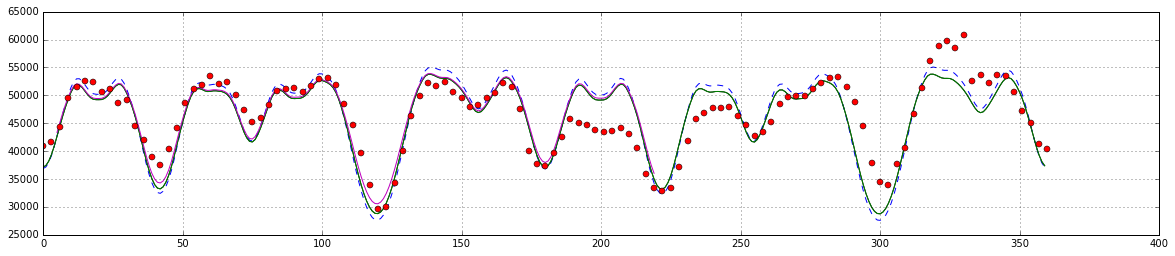

In [18]:
plt.figure(figsize=(20,4))

plt.plot(vWD,dwm_dominant_avg_o['power'],'b--') # initial folder DWMpython 
plt.plot(vWD,dwm_dominant_avg_on['power']*0.94,'k-')  # new implementation using different turbine model needs to convert to elec power
plt.plot(vWD,dwm_dominant_avg_on_pc['power']*0.94,'g-')  # new implementation with old specs
plt.plot(vWD,dwm_dominant_avg_on_pc_noacc['power']*0.94,'m-') 
plt.grid(True)
df_data = pd.read_csv('../data/LillgrundEfficiency/Meas-Kurt/efficiency.dat', sep= '\s*', engine= 'python')
df_data['eff'] /= 100.
scada,=plt.plot(df_data['wd'],df_data['eff']* (nom_power*1.06* WF.nWT),'ro',label='DATA',linewidth=2)

In [11]:
# Perform rolling average Gaumont et al.
dwm_dominant_avg_e = my_rolling_deg(dwm_dominant_o, x='wd', y='eff',dwd=5.)
dwm_dominant_avg_en = my_rolling_deg(dwm_dominant_on, x='wd', y='eff',dwd=5.)
dwm_dominant_avg_en_pc = my_rolling_deg(dwm_dominant_on_pc, x='wd', y='eff',dwd=5.)

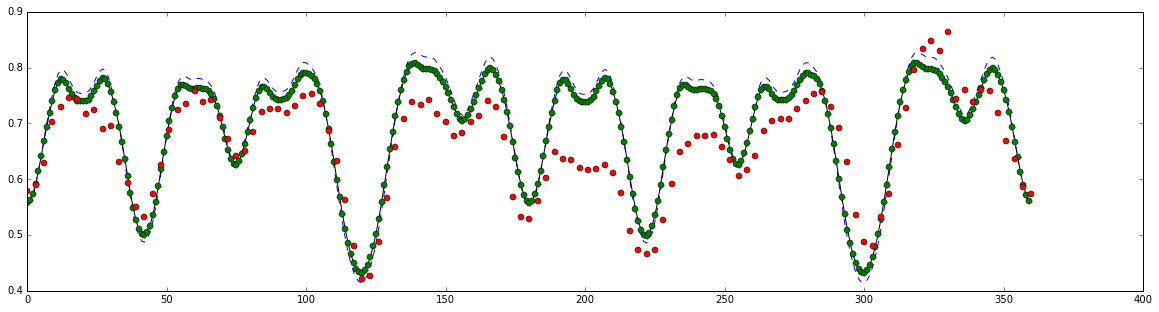

In [9]:
plt.figure(figsize=(20,5))

plt.plot(vWD,dwm_dominant_avg_e['eff'],'b--') # initial folder DWMpython 
plt.plot(vWD,dwm_dominant_avg_en['eff']*0.94,'k+-')  # new implementation using different turbine model needs to convert to elec power
plt.plot(vWD,dwm_dominant_avg_en_pc['eff']*0.94,'go')  # new implementation with old specs
df_data = pd.read_csv('../data/LillgrundEfficiency/Meas-Kurt/efficiency.dat', sep= '\s*', engine= 'python')
df_data['eff'] /= 100.
scada,=plt.plot(df_data['wd'],df_data['eff'],'ro',label='DATA',linewidth=2)